In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [ ]:
import pandas as pd

csv_path = "/content/drive/My Drive/MIDOG25_Atypical_Classification_Train_Set.csv"
df = pd.read_csv(csv_path)

print(df.columns)  # Inspect column names


Index(['image_id', 'filename', 'coordinateX', 'coordinateY', 'Tumor',
       'Scanner', 'Origin', 'Species', 'expert1', 'expert2', 'expert3',
       'majority'],
      dtype='object')


In [ ]:
image_dir = "/content/drive/My Drive/MIDOG25_Binary_Classification_Train_Set/"
df['filename'] = df['filename'].apply(lambda x: x.replace(".tiff", ".png"))
df['filepath'] = image_dir + df['filename']


In [ ]:
label_map = {'NMF': 0, 'AMF': 1}
df['label'] = df['majority'].map(label_map)

# Drop rows where image is missing (important!)
import os
df = df[df['filepath'].apply(os.path.exists)]


In [ ]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    df['filepath'].values,
    df['label'].values,
    test_size=0.2,
    stratify=df['label'].values,
    random_state=42
)


In [ ]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = (train_ds
    .shuffle(1000)
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (val_ds
    .map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


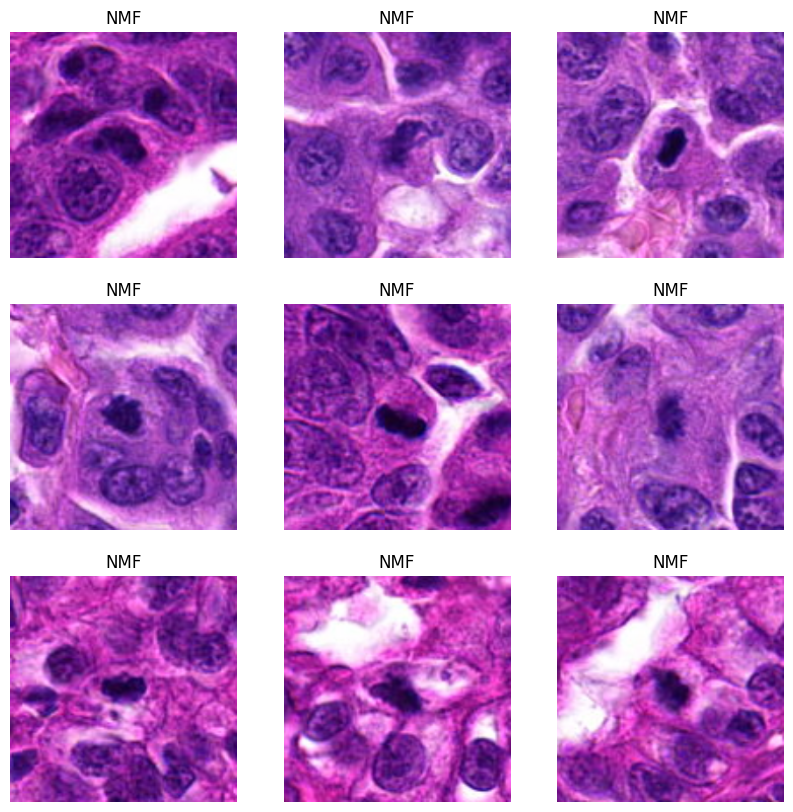

In [ ]:
import matplotlib.pyplot as plt

class_names = ['NMF', 'AMF']

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")


CNN


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 122s 403ms/step - accuracy: 0.8340 - loss: 0.4689 - val_accuracy: 0.8603 - val_loss: 0.4453
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 60s 139ms/step - accuracy: 0.8532 - loss: 0.4201 - val_accuracy: 0.8603 - val_loss: 0.4147
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.8556 - loss: 0.4026 - val_accuracy: 0.8603 - val_loss: 0.3792
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.8582 - loss: 0.3914 - val_accuracy: 0.8603 - val_loss: 0.3788
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.8594 - loss: 0.3908 - val_accuracy: 0.8603 - val_loss: 0.3786


In [ ]:
from collections import Counter

label_counter = Counter()

for _, labels in train_ds.unbatch():
    label_counter[int(labels.numpy())] += 1

print("Label distribution in train_ds:", label_counter)


Label distribution in train_ds: Counter({0: 7536, 1: 1222})



Compute Class Weights

In [ ]:
# Step 1a: Encode 'majority' column to numeric labels
label_map = {'NMF': 0, 'AMF': 1}
df['label'] = df['majority'].map(label_map)

# Step 1b: Build full path for each image
image_dir = '/content/drive/My Drive/MIDOG25_Binary_Classification_Train_Set'
df['filepath'] = df['filename'].apply(lambda x: os.path.join(image_dir, x.replace('.tiff', '.png')))

# Step 1c: Create dictionary {filepath: label}
path_to_label = dict(zip(df['filepath'], df['label']))


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.5810774946921444), 1: np.float64(3.583469721767594)}


Common Setup (for both models)



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50

IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)

# This stays the same for both models
base_input = tf.keras.Input(shape=INPUT_SHAPE)

MobileNetV2 Model



In [ ]:
mobilenet_base = MobileNetV2(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
mobilenet_base.trainable = False  # Freeze base

mobilenet_model = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict
)


Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - accuracy: 0.5256 - loss: 0.8086 - val_accuracy: 0.6753 - val_loss: 0.6282
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - accuracy: 0.5638 - loss: 0.7195 - val_accuracy: 0.5416 - val_loss: 0.7078
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 0.5938 - loss: 0.6676 - val_accuracy: 0.6822 - val_loss: 0.6080
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.6107 - loss: 0.6751 - val_accuracy: 0.6950 - val_loss: 0.5768
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.6064 - loss: 0.6516 - val_accuracy: 0.7982 - val_loss: 0.5071


ResNet

In [ ]:
resnet_base = ResNet50(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
resnet_base.trainable = False  # Freeze base

resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weight_dict
)


Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 59s 161ms/step - accuracy: 0.5123 - loss: 0.7149 - val_accuracy: 0.1397 - val_loss: 0.7380
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 66s 124ms/step - accuracy: 0.4808 - loss: 0.6996 - val_accuracy: 0.8603 - val_loss: 0.6281
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - accuracy: 0.5063 - loss: 0.7101 - val_accuracy: 0.1543 - val_loss: 0.7093
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.5243 - loss: 0.6983 - val_accuracy: 0.8603 - val_loss: 0.6351
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.5117 - loss: 0.7036 - val_accuracy: 0.1397 - val_loss: 0.8506


In [ ]:
from collections import Counter
y_val = []
for _, labels in val_ds.unbatch():
    y_val.append(int(labels.numpy()))
print(Counter(y_val))


Counter({0: 1884, 1: 306})


In [ ]:
df['label'] = df['majority'].map({'NMF': 0, 'AMF': 1})  # or reverse if needed


In [ ]:
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label


In [ ]:
base_model.trainable = False  # freeze base


In [ ]:
resnet_model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 154ms/step - accuracy: 0.8128 - loss: 0.4526 - val_accuracy: 0.8603 - val_loss: 0.4035
Epoch 2/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 68s 117ms/step - accuracy: 0.8586 - loss: 0.4092 - val_accuracy: 0.8603 - val_loss: 0.4060
Epoch 3/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.8626 - loss: 0.4037 - val_accuracy: 0.8603 - val_loss: 0.4037
Epoch 4/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 31s 114ms/step - accuracy: 0.8580 - loss: 0.4104 - val_accuracy: 0.8603 - val_loss: 0.4027
Epoch 5/5
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.8641 - loss: 0.4001 - val_accuracy: 0.8603 - val_loss: 0.4055
